In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import os
import pandas as pd

2025-09-04 15:58:35.233931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-04 15:58:35.281043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-04 15:58:36.155999: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
EPOCHS = 20
BATCH_SIZE = 64
CLASSES = 2
IMAGE_SIZE = 256
LR = 0.0003

In [ ]:
dataset_root = Path("Dataset")
train_dir = Path("Dataset/train")
val_dir   = Path("Dataset/val")
test_dir  = Path("Dataset/test")

   Split      Class  Samples
0  train     NORMAL     1341
1  train  PNEUMONIA     3875
2    val     NORMAL        8
3    val  PNEUMONIA        8
4   test     NORMAL      234
5   test  PNEUMONIA      390


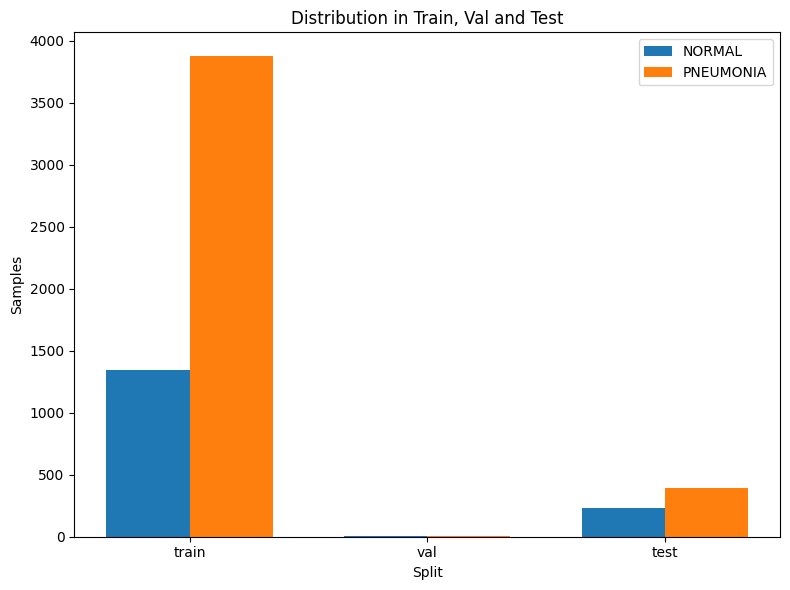

In [ ]:

data_counts = []

for split in ["train", "val", "test"]:
    split_path = os.path.join(dataset_root, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            data_counts.append({
                "Split": split,
                "Class": class_name,
                "Samples": count
            })

df_counts = pd.DataFrame(data_counts)
print(df_counts)

df_counts.to_csv("dataset_distribution.csv", index=False)


plt.figure(figsize=(8,6))

splits = df_counts["Split"].unique()
classes = df_counts["Class"].unique()
bar_width = 0.35
x = range(len(splits))

for i, cls in enumerate(classes):
    counts = [df_counts[(df_counts["Split"]==split) & (df_counts["Class"]==cls)]["Samples"].values[0] for split in splits]
    plt.bar([pos + i*bar_width for pos in x], counts, width=bar_width, label=cls)

plt.xticks([r + bar_width/2 for r in x], splits)
plt.xlabel("Split")
plt.ylabel("Samples")
plt.title("Distribution in Train, Val and Test")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                     shear_range = 0.1,
                                     zoom_range = 0.1,
                                     #horizontal_flip = True,
                                    #  rotation_range=5,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     fill_mode='constant'
                                   )
training_set = train_datagen.flow_from_directory(train_dir, 
                                                target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size = BATCH_SIZE,
                                                color_mode= "grayscale",
                                                class_mode = 'binary')

Found 5216 images belonging to 2 classes.


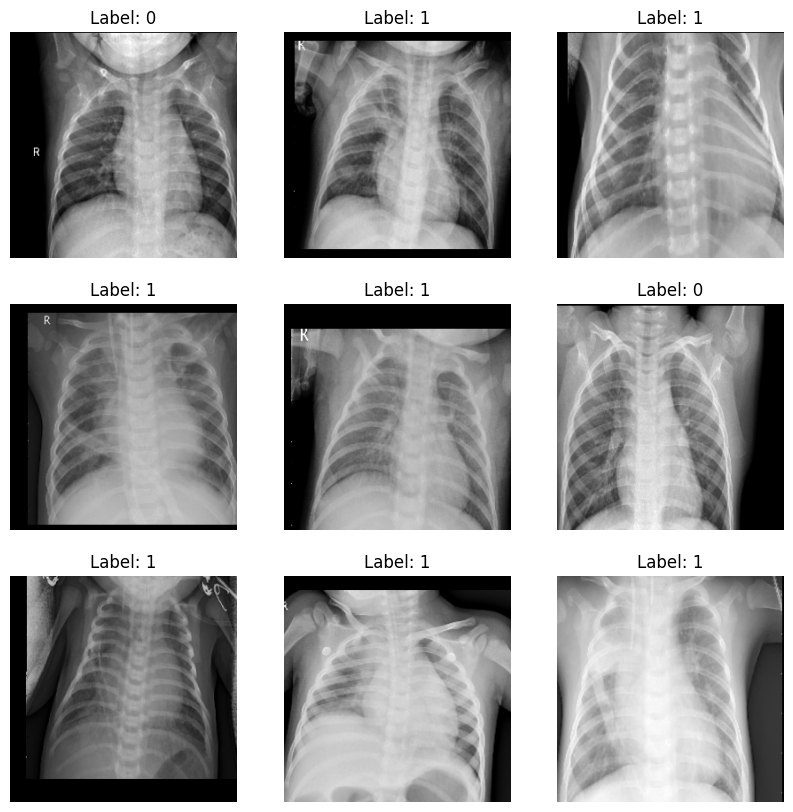

In [ ]:
import matplotlib.pyplot as plt

X_batch, y_batch = next(training_set)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    if X_batch[i].shape[-1] == 1:
        plt.imshow(X_batch[i].squeeze(), cmap="gray")
    else:
        plt.imshow(X_batch[i])
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis("off")

plt.show()


In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255) 

validation_set = val_datagen.flow_from_directory(val_dir,
                                                target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size = BATCH_SIZE,
                                                color_mode="grayscale",
                                                class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                           target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'binary',
                                           color_mode="grayscale",
                                           shuffle = False)

Found 624 images belonging to 2 classes.


In [ ]:
cnn = tf.keras.models.Sequential()

# cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1], padding='same', strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1] ))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.3))


cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)  
# Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)  

cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/home/diego/uni/magistrale/DL/DL-exam/Chest-X-Ray-Images-Pneumonia-DL-exam/dl_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756994318.027585   51301 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes = np.unique(training_set.classes),
    y=training_set.classes
)
class_weights = dict(enumerate(class_weights))
# class_weights = {0: 1.5, 1: 1.0}
model_eval = cnn.fit(training_set, validation_data=validation_set, epochs=EPOCHS, class_weight=class_weights, callbacks=[lr_scheduler])
# model_eval = cnn.fit(training_set, validation_data=validation_set, epochs=EPOCHS, class_weight=class_weights)
cnn.save("Models/cnn.h5")


/home/diego/uni/magistrale/DL/DL-exam/Chest-X-Ray-Images-Pneumonia-DL-exam/dl_venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-09-04 15:58:40.159400: I external/local_xla/xla/service/service.cc:163] XLA service 0x758970009390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-04 15:58:40.159433: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-09-04 15:58:40.185506: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-04 15:58:40.324569: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-09-04 15:58:40.825448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_853', 880 bytes spill stores, 880 bytes spill loads



 2/82 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7695 - loss: 1.2762

I0000 00:00:1756994325.593559   51423 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - accuracy: 0.7188 - loss: 0.6072 - val_accuracy: 0.8750 - val_loss: 0.3215 - learning_rate: 3.0000e-04
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.8844 - loss: 0.2776 - val_accuracy: 0.9375 - val_loss: 0.2584 - learning_rate: 3.0000e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.9055 - loss: 0.2261 - val_accuracy: 0.8750 - val_loss: 0.3201 - learning_rate: 3.0000e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.8976 - loss: 0.2366 - val_accuracy: 0.7500 - val_loss: 0.6022 - learning_rate: 3.0000e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8903 - loss: 0.2685
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.9020 - loss: 0.2343 - val_accuracy: 0.8125 - val_loss: 0.4005 - learning_rate: 3.0000e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.9268 - l

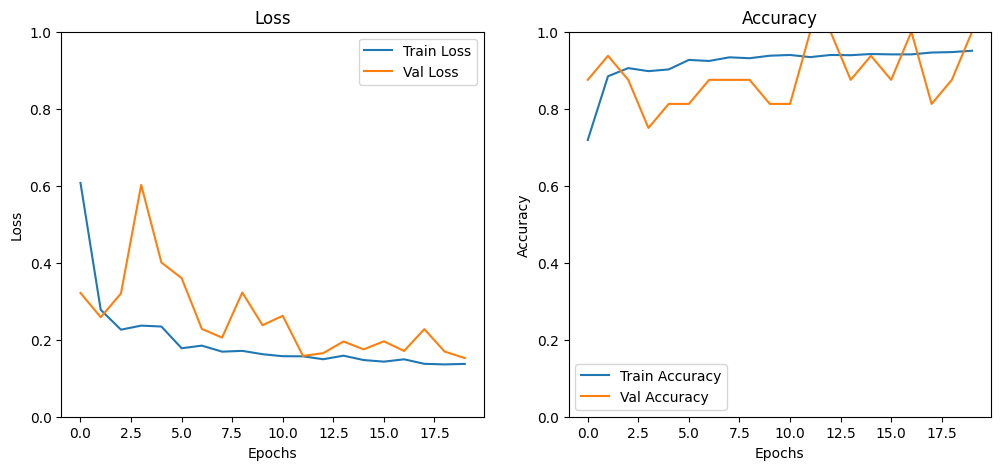

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.86      0.86      0.86       234
   PNEUMONIA       0.92      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



<Figure size 800x800 with 0 Axes>

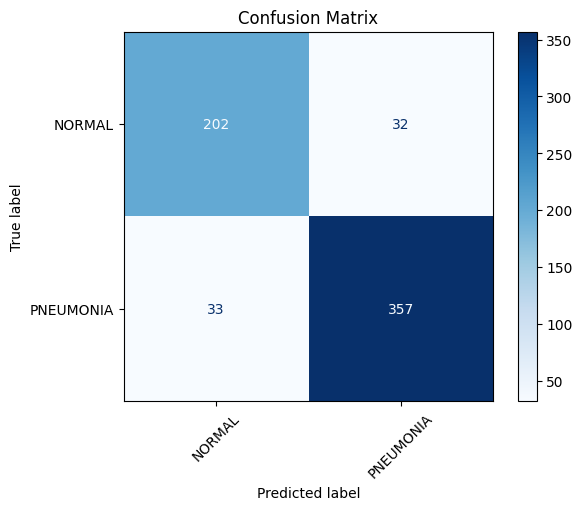

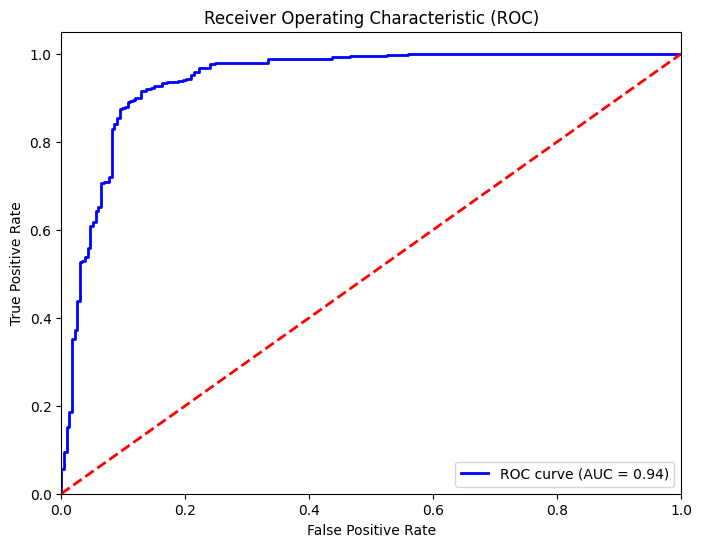

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


# === 1. plot of loss and accuracy ===
history = model_eval.history  

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0, 1)
plt.title("Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.ylim(0, 1)
plt.show()

# === 2. prediction on test set ===
y_pred = cnn.predict(test_set)
y_pred_classes = (y_pred > 0.5).astype("int32") # threshold 0.5
y_true = test_set.classes

# === 3. Classification report ===
target_names = list(test_set.class_indices.keys())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# === 4. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8,8))
disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
plt.title("Confusion Matrix")

plt.show()

# === 5. ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Image NORMAL/IM-0001-0001.jpeg: NORMAL
Image NORMAL/IM-0003-0001.jpeg: NORMAL
Image NORMAL/IM-0005-0001.jpeg: NORMAL
Image NORMAL/IM-0006-0001.jpeg: NORMAL
Image NORMAL/IM-0007-0001.jpeg: NORMAL
Image NORMAL/IM-0009-0001.jpeg: NORMAL
Image NORMAL/IM-0010-0001.jpeg: NORMAL
Image NORMAL/IM-0011-0001-0001.jpeg: NORMAL
Image NORMAL/IM-0011-0001-0002.jpeg: NORMAL
Image NORMAL/IM-0011-0001.jpeg: NORMAL
Image NORMAL/IM-0013-0001.jpeg: NORMAL
Image NORMAL/IM-0015-0001.jpeg: NORMAL
Image NORMAL/IM-0016-0001.jpeg: NORMAL
Image NORMAL/IM-0017-0001.jpeg: NORMAL
Image NORMAL/IM-0019-0001.jpeg: NORMAL
Image NORMAL/IM-0021-0001.jpeg: NORMAL
Image NORMAL/IM-0022-0001.jpeg: PNEUMONIA
Image NORMAL/IM-0023-0001.jpeg: NORMAL
Image NORMAL/IM-0025-0001.jpeg: NORMAL
Image NORMAL/IM-0027-0001.jpeg: NORMAL
Image NORMAL/IM-0028-0001.jpeg: NORMAL
Image NORMAL/IM-0029-0001.jpeg: NORMAL
Image NORMAL/IM-0030-0001.jpeg: NORMAL
Image NORMAL/IM-0031-0001.jpeg: NORMAL
Image NORM

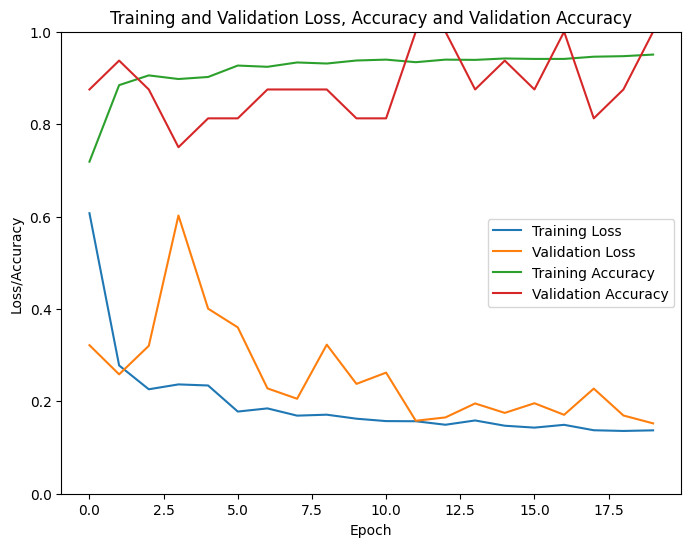

In [ ]:
# Get class label mapping from the generator
class_labels = {v: k for k, v in test_set.class_indices.items()}

# Make predictions on the whole batch
predictions = cnn.predict(test_set)
pred_class = (predictions > 0.5).astype("int32") # threshold 0.5

# Display predictions (you can map indices to your actual class labels)
for i, prediction in enumerate(pred_class):
    label = class_labels[prediction[0]]
    print(f'Image {test_set.filenames[i]}: {label}')


# Plot training and validation loss values
plt.figure(figsize=(8,6))
plt.plot(model_eval.history['loss'], label='Training Loss')
plt.plot(model_eval.history['val_loss'], label='Validation Loss')

plt.plot(model_eval.history['accuracy'], label='Training Accuracy')
plt.plot(model_eval.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Loss, Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()